<a href="https://colab.research.google.com/github/mezkymy/diabetes-prediction/blob/dev/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from imblearn.over_sampling import RandomOverSampler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, jaccard_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# set random state for consistency on random methods results
random_state = 22

# Diabetes Prediction Model

Data Source: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

<b>Context (copied from Kaggle):</b>

The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

In [3]:
# load data
raw_data = pd.read_csv('https://raw.githubusercontent.com/mezkymy/diabetes-prediction/main/diabetes_prediction_dataset.csv')
df = raw_data.copy()
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# check columns info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
# descriptive statisics for numerical type
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
# descriptive statisics for object type
df.select_dtypes(['object']).describe()

,gender,smoking_history
count,100000,100000
unique,3,6
top,Female,No Info
freq,58552,35816


For string/categorical columns, there are only a few unique values on each column. For modeling purposes, using One-hot encoding should be viable for both columns.

# Exploratory Data Analysis

## Distribution Based on Numerical Features

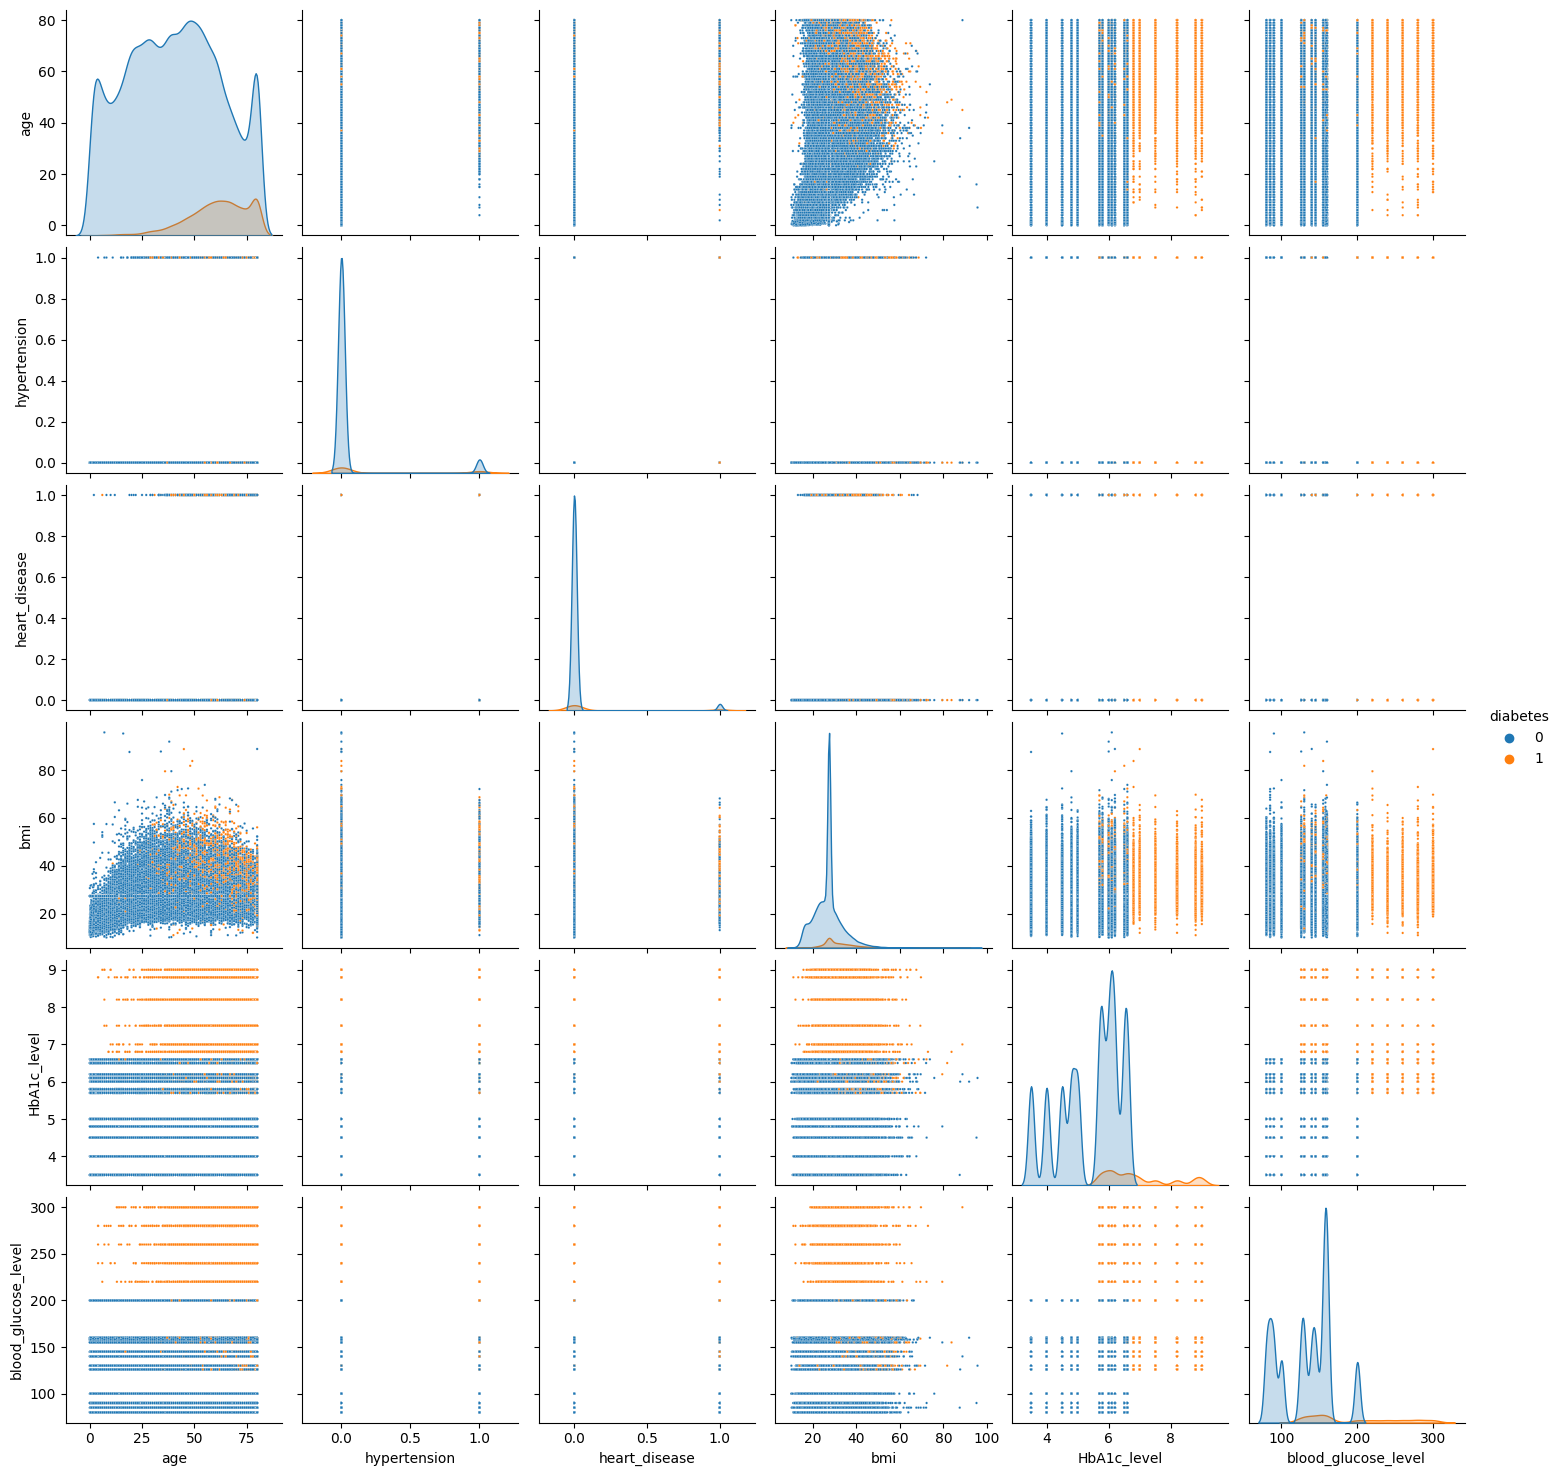

In [7]:
# show scatter plots between numerical columns
sns.pairplot(df, hue='diabetes', plot_kws={"s": 3})
plt.show()

Based on the pair plot above, we can gather some insights visually:
1. As stated in the data source, blood glucose level is one of the key indicator of diabetes. It is proven by visually looking at the distribution based on hue, where above 200 there are no patients that are not diagnosed with diabetes, while only a relatively small portion of patients with lower than 200 blood glucose level are diagnosed with diabetes
2. Furthermore, HbA1c_level or the measure of a person's average blood sugar level over the past 2-3 months segments patients even more, where those with blood glucose level somewhere between 100-150 but also with HbA1c level above ~7 are diagnosed with diabetes. This seperates the small portion of patients mentioned on point 1
3. No patients with blood glucose level above 200 have a HbA1c level of below ~5. At the same time, no patients with lower than ~125 blood glucose level have a HbA1c level of above ~7. Since blood glucose level are measured at a given time while HbA1c are measured on average over the past 2-3 months, this shows that both features are indeed correlated to each other, although blood glucose level at a given time might change drastically compared to its average over 2-3 months
4. Judging visually, a higher age means a higher risk of having diabetes, while hypertension and heart disease does not always indicate diabetes. Body mass index also are not visually correlated to diabetes
5. BMI are either heavily skewed, or there are some outliers that might need to be treated or removed

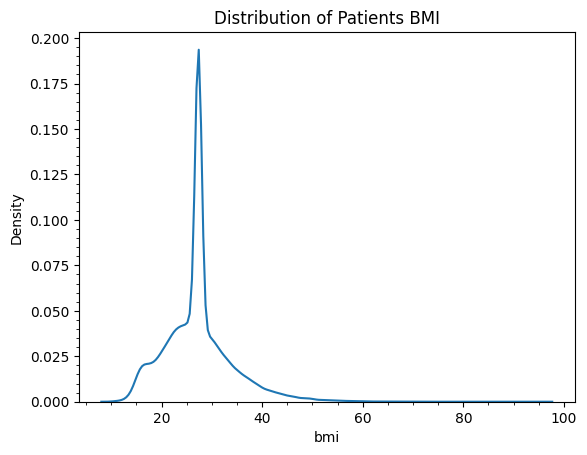

In [8]:
# check bmi distribution with box plot
sns.kdeplot(data=df, x="bmi").set(title="Distribution of Patients BMI")

plt.minorticks_on()
plt.show()

As seen on the graph above, BMI is positively skewed, where the majority of patient's BMI are on the range of 20 to 40 but with some having up to 100. Rather than having to remove several outliers, it might be better to transform BMI with log transformation, hopefully to show a more normal distribution of BMI. 

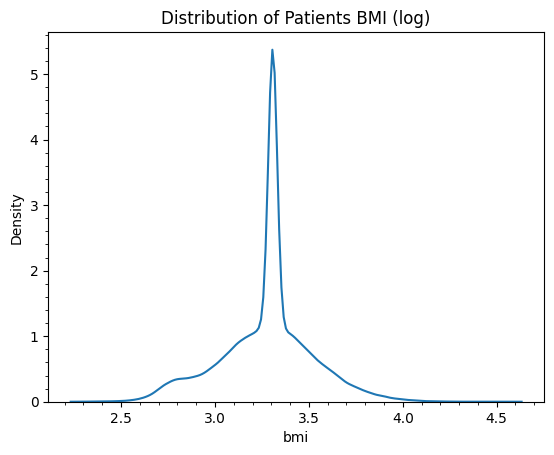

In [9]:
# try to plot log of BMI
sns.kdeplot(data=df, x=np.log(df['bmi'])).set(title="Distribution of Patients BMI (log)")

plt.minorticks_on()
plt.show()

After a log transformation, BMI seems to be quite normally distributed and also may not require any outlier removal. Log transformation will be applied to BMI at the pipeline.

In [10]:
# check max level of HbA1c and blood_glucose_level on non-diabetes patients
df[df['diabetes'] == 0].describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,91500.000000,91500.000000,91500.000000,91500.000000,91500.000000,91500.000000,91500.0
mean,40.115187,0.058984,0.029235,26.887163,5.396761,132.852470,0.0
std,22.306005,0.235595,0.168465,6.373406,0.971628,34.247281,0.0
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.0
25%,22.000000,0.000000,0.000000,23.240000,4.800000,100.000000,0.0
50%,40.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.0
75%,57.000000,0.000000,0.000000,28.870000,6.200000,158.000000,0.0
max,80.000000,1.000000,1.000000,95.690000,6.600000,200.000000,0.0


In [11]:
# check max level of HbA1c and blood_glucose_level on diabetes patients
df[df['diabetes'] == 1].describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.0
mean,60.946588,0.245647,0.149059,31.988382,6.934953,194.094706,1.0
std,14.549880,0.430496,0.356167,7.558371,1.076562,58.641111,0.0
min,3.000000,0.000000,0.000000,10.980000,5.700000,126.000000,1.0
25%,52.000000,0.000000,0.000000,27.320000,6.100000,145.000000,1.0
50%,62.000000,0.000000,0.000000,29.970000,6.600000,160.000000,1.0
75%,72.000000,0.000000,0.000000,35.912500,7.500000,240.000000,1.0
max,80.000000,1.000000,1.000000,88.720000,9.000000,300.000000,1.0


Based on blood glucose level and HbA1c level, we can categorize patients into two categories:

1. Patients with HbA1c level 6.6 and below, AND with blood glucose level 200 and below, shall be categorized as category A. Patients on this category should be mostly diabetes-free
2. Other patients should be categorized as category A, where patients are diagnosed with diabetes

Since there are only two categories, a binary column would be sufficient to categorize patients based on this criterias.

In [12]:
# categorize glucose level
df['glucose_level_risk'] = np.where((df['blood_glucose_level'] <= 200) & (df['HbA1c_level'] <= 6.6), 0, 1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,glucose_level_risk
0,Female,80.0,0,1,never,25.19,6.6,140,0,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,0
3,Female,36.0,0,0,current,23.45,5.0,155,0,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,0


In [13]:
df[df['glucose_level_risk'] == 0]['diabetes'].mean()

0.029826216958425668

In [14]:
df[df['glucose_level_risk'] == 1]['diabetes'].mean()

1.0

Based on its mean/average value, it can be deducted that even if a patient have lower than 200 blood glucose level and 6.6 HbA1c level, they can still be diagnosed with diabetes albeit with a relatively low chance. Patients that exceeds any of those levels however are guaranteed to be diagnosed with diabetes.

In [15]:
# check patients with 0 level risk but diagnosed with diabetes
df[(df['glucose_level_risk'] == 0) & (df['diabetes'] == 1)]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,glucose_level_risk
6,Female,44.0,0,0,never,19.31,6.5,200,1,0
26,Male,67.0,0,1,not current,27.32,6.5,200,1,0
96,Female,67.0,0,0,never,27.32,6.2,159,1,0
242,Male,57.0,1,1,not current,27.77,6.6,160,1,0
253,Female,64.0,0,0,never,27.32,6.2,155,1,0
...,...,...,...,...,...,...,...,...,...,...
99694,Female,39.0,0,0,never,32.04,5.7,200,1,0
99723,Male,61.0,1,1,former,35.78,6.0,145,1,0
99829,Male,58.0,0,0,former,32.38,6.6,159,1,0
99845,Female,43.0,1,0,never,34.21,6.5,160,1,0


## Distribution Based on Categorical Features

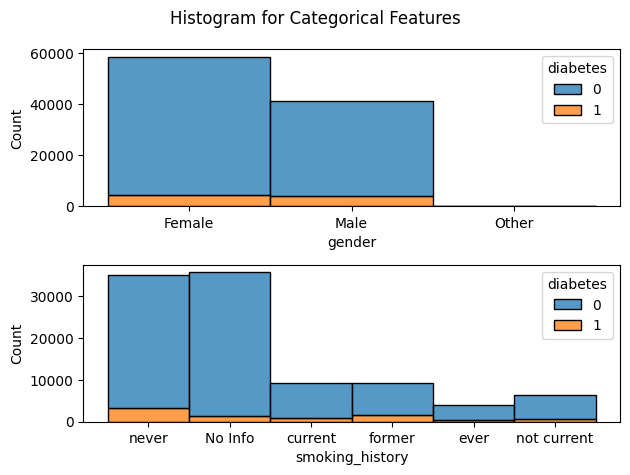

In [16]:
# Create histplot for categorical columns
cat_columns = list(df.select_dtypes(['object']).columns.values)

fig, axes = plt.subplots(2, 1)

i = 0
for ax in axes:
    col = cat_columns[i]
    sns.histplot(df, x=col, hue='diabetes', multiple='stack', ax=ax)
    i += 1

plt.suptitle('Histogram for Categorical Features')
plt.tight_layout()
plt.show()

Visually speaking, the number of males diagnosed with diabetes are identical with females, but the number of males not diagnosed with diabetes are significantly lower, which might lead to the assumption that males have a higher risk of being diagnosed with diabetes.

For smoking history, it might be easier to obtain insights by looking at the ratios instead of the count.

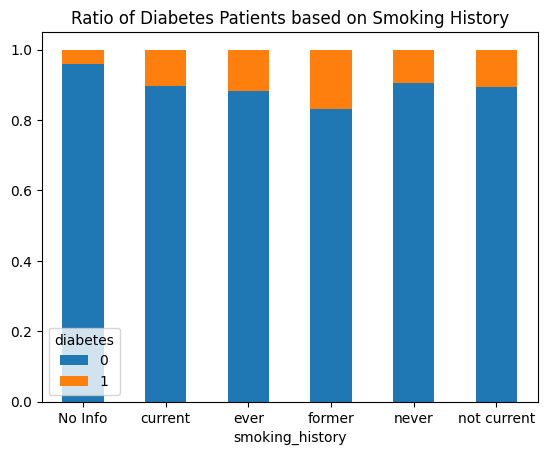

In [17]:
ct = pd.crosstab(index=df['smoking_history'],columns=df['diabetes'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.title('Ratio of Diabetes Patients based on Smoking History')
plt.show()

Although those who have never smoked might have a lower chance of being diagnosed with diabetes (excluding those without info), those who are on the former category seems to be more susceptible to diabetes than even those who are still actively smoking. 

This might be due to the amount of smoking that is actually related to diabetes (for example, those who are on the former category smoked way more on the past than those who are still smoking currently), or that smoking history does not have a strong, significant correlation to diabetes.

Because "No Info" means that the patient might fall into any of the other categories and the number of patients having no info on their smoking history are too large, it might be better to drop this feature, as including it as is might lead to bias, where the actual ratios of each category might not be as presented on the chart above.

If the relationship between smoking history and diabetes are proven scientifically, then a stricter data collection process must be ensured to minimize the number of patients with no info on their smoking history.

In [18]:
# drop smoking_history column
df.drop(columns='smoking_history', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  int64  
 8   glucose_level_risk   100000 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 6.9+ MB


## Correlation Matrix

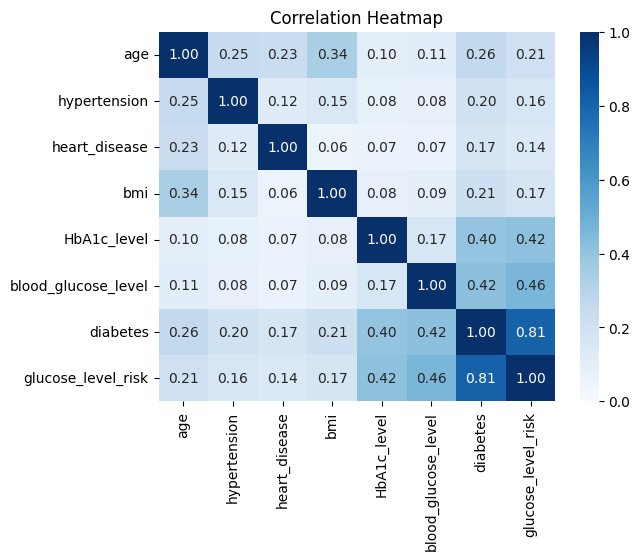

In [19]:
# correlation heatmap with pearson
fig, ax = plt.subplots()
sns.heatmap(df.corr(method='pearson', numeric_only=True), annot=True, cmap='Blues', vmin=0, vmax=1, fmt='.2f')

plt.title('Correlation Heatmap')
plt.show()

Based on the correlation matrix above, no features are negatively correlated to diabetes, and the values are all above 0,15. This signifies that all features might positively contribute/correlate to diabetes, although some of them (age, hypertension, heart disease, and body mass index) have a significantly lower coefficient than the other three (HBA1c level, blood glucose level, and their derivative which is glucose level risk).

# Preprocessing

## Train-Test Split

In [20]:
# split data into features & target
target = 'diabetes'
features = df.loc[:, df.columns != target].columns

X_data = df[features]
y_data = df[target]

# split data by 80:20 for train:test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state, stratify=y_data)

# check amount of data on train and test
print('train data count =', X_train.shape[0])
print('test data count  =', X_test.shape[0])

train data count = 80000
test data count  = 20000


## Handling Missing Values and Duplicated Data
From `.info()` method, there are no columns detected with a null value.

Although duplicated data are usually removed in analysis and modeling, based on the features on the dataset duplicates are bound to happen since it is possible for different patients to have the same values on all features on the dataset. Therefore, no duplicates should be removed.

## Transformation and Encoding Pipeline

In [21]:
# for BMI, apply log transformation and MinMaxScaler
bmi_transformer = Pipeline(
    steps=[
        ('logtransformer', FunctionTransformer(np.log)),
        ('scaler', MinMaxScaler()),
    ]
)

# use MinMaxScaler for other numerical columns (other than binary)
num_col = ['age', 'HbA1c_level', 'blood_glucose_level']
num_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
    ]
)

# use OneHotEncoder for gender, drop Other (shall be represented as male=0 and female=0)
ohe_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop=['Other'])),
    ]
)


# finalize column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', bmi_transformer, ['bmi']),
        ('num', num_transformer, num_col),
        ('ohe', ohe_transformer, ['gender']),
    ],
    remainder='passthrough'
)

## Handle Imbalances
Based on the target mean value, there are only around ~8% of patients diagnosed with diabetes in the whole dataset, compared to the ~92% of patients not diagnosed with diabetes. This imbalance might lead to an underperforming model, especially when the necessity to predict the minority (patients with diabetes) is greater than to predict the majority. 

In [22]:
ros = RandomOverSampler(random_state=random_state)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

X_train_resampled.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,glucose_level_risk
count,146400.000000,146400.000000,146400.000000,146400.000000,146400.000000,146400.000000,146400.000000
mean,50.570631,0.156134,0.091728,29.467802,6.163512,163.309187,0.333033
std,21.501255,0.362983,0.288643,7.459436,1.277787,56.791960,0.471300
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,36.000000,0.000000,0.000000,25.790000,5.700000,130.000000,0.000000
50%,54.000000,0.000000,0.000000,27.320000,6.100000,155.000000,0.000000
75%,67.000000,0.000000,0.000000,32.910000,6.600000,200.000000,1.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [23]:
# check average of target to see distribution ratio
y_train_resampled.mean()

0.5

# Choose Model Type

In [24]:
def cross_validation(features, target, models, cv):
    model_name = []

    cv_accuracy_mean = []
    cv_accuracy_std = []
    training_accuracy = []

    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []

    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    for name, model in models:
    
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ]) 
        model_name.append(name)

        #scoring
        scoring= ['accuracy', 'precision', 'recall']

        # test
        cv_score = cross_validate(pipeline, features, target, scoring=scoring, cv=cv, n_jobs=-1)

        cv_accuracy_mean.append(cv_score['test_accuracy'].mean())
        cv_accuracy_std.append(cv_score['test_accuracy'].std())

        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())

        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())

        # training
        pipeline.fit(features, target)
        y_pred = pipeline.predict(X_test)
        training_accuracy.append(accuracy_score(y_test, y_pred))
        training_precision.append(precision_score(y_test, y_pred))
        training_recall.append(recall_score(y_test, y_pred))
    
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy': training_accuracy,
        'CV Accuracy (mean)': cv_accuracy_mean,
        'CV Accuracy (std)' : cv_accuracy_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)': cv_precision_mean,
        'CV Precision (std)': cv_precision_std,
        'Training Recall' : training_recall,
        'CV Recall (mean)' : cv_recall_mean,
        'CV Recall (std)' : cv_recall_std
    })

In [25]:
models = [
    ['Decision Tree', DecisionTreeClassifier(random_state=random_state)],
    ['Random Forest', RandomForestClassifier(random_state=random_state)],
    ['Logistic Regression', LogisticRegression(random_state=random_state, solver='sag')],
    ['KNN', KNeighborsClassifier()],
    ['XGBoost', XGBClassifier()],
]

cv_result = cross_validation(X_train_resampled, y_train_resampled, models, 5)
cv_result

,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Precision,CV Precision (mean),CV Precision (std),Training Recall,CV Recall (mean),CV Recall (std)
0,Decision Tree,0.95275,0.983620,0.000329,0.715345,0.968776,0.000683,0.737647,0.999454,0.000290
1,Random Forest,0.96200,0.989023,0.000247,0.806389,0.978941,0.000489,0.727647,0.999549,0.000272
2,Logistic Regression,0.91230,0.887268,0.001204,0.491036,0.907762,0.001937,0.870000,0.862145,0.002390
3,KNN,0.92930,0.962561,0.000732,0.557895,0.933004,0.001139,0.810588,0.996694,0.000433
4,XGBoost,0.92240,0.940902,0.001857,0.526297,0.925788,0.000821,0.871176,0.958648,0.003174


## XGBoost

In [1]:
# combine preprocessing and classifier into a single pipeline 
xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('classifier', XGBClassifier(random_state=random_state))
    ]
)

# hyperparameter combinations
param_grid = {
    'classifier__eta' : [0.5, 0.3, 0.1, 0.05, 0.01, 0.005],
    'classifier__max_depth' : range(2, 12, 2),
    'classifier__subsample' : np.linspace(0.5, 0.9, 5),
}

# iterate with Randomized Search
rs = RandomizedSearchCV(xgb_pipe, param_grid, n_iter=50, n_jobs=-1, cv=5, scoring='recall', random_state=random_state)
rs.fit(X_train_resampled, y_train_resampled)

# print the best hyperparameters
print('Best hyperparameters using randomized search:', rs.best_params_)

NameError: ignored

In [28]:
# masukkan hasil dari best_params_ ke dalam classifier baru
xgb_best_clf = XGBClassifier(random_state=random_state, subsample=0.9, max_depth=10, eta=0.17) 

# buat pipeline
xgb_best = Pipeline( 
    steps = [ 
        ('preprocessor', preprocessor),
        ('classifier', xgb_best_clf)
    ]
)

# fit pipeline dengan data train
xgb_best.fit(X_train_resampled, y_train_resampled)

# evaluate model
y_train_pred = xgb_best.predict(X_train_resampled)
y_pred = xgb_best.predict(X_test)

# main model evaluation: precision
print('Recall score data TRAIN :', round(recall_score(y_train_resampled, y_train_pred)*100, 3), '%')
print('Recall score data TEST  :', round(recall_score(y_test, y_pred)*100, 3), '%')

# other scores
print('\nOther Scores (based on test data):\n')
print('Accuracy score :', round(accuracy_score(y_test, y_pred)*100, 3), '%')
print('F-1 score :', round(f1_score(y_test, y_pred)*100, 3), '%')
print('Precision score :', round(precision_score(y_test, y_pred)*100, 3), '%')
print('Jaccard score :', round(jaccard_score(y_test, y_pred)*100, 3), '%')

Recall score data TRAIN : 98.373 %
Recall score data TEST  : 83.588 %

Other Scores (based on test data):

Accuracy score : 93.875 %
F-1 score : 69.88 %
Precision score : 60.034 %
Jaccard score : 53.704 %


In [29]:
# Logistic Regression
# remove HbA1c and blood_glucose_level from pipeline since it is already represented by the feature glucose_level_risk
# for BMI, apply log transformation and MinMaxScaler
bmi_transformer = Pipeline(
    steps=[
        ('logtransformer', FunctionTransformer(np.log)),
        ('scaler', MinMaxScaler()),
    ]
)

# use MinMaxScaler for age
age_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
    ]
)

# use OneHotEncoder for gender, drop 'Other' (shall be represented as male=0 and female=0)
ohe_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop=['Other'])),
    ]
)


# finalize column transformer
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', bmi_transformer, ['bmi']),
        ('age', age_transformer, ['age']),
        ('ohe', ohe_transformer, ['gender']),
        ('dropcol', 'drop', ['HbA1c_level', 'blood_glucose_level'])
    ],
    remainder='passthrough'
)

In [30]:
# buat pipeline
lr = Pipeline( 
    steps = [ 
        ('preprocessor', linear_preprocessor),
        ('classifier', LogisticRegression(random_state=random_state))
    ]
)

# fit pipeline dengan data train
lr.fit(X_train_resampled, y_train_resampled)

# evaluate model
y_train_pred = lr.predict(X_train_resampled)
y_pred = lr.predict(X_test)

# main model evaluation: precision
print('Recall score data TRAIN :', round(recall_score(y_train_resampled, y_train_pred)*100, 3), '%')
print('Recall score data TEST  :', round(recall_score(y_test, y_pred)*100, 3), '%')

# other scores
print('\nOther Scores (based on test data):\n')
print('Accuracy score :', round(accuracy_score(y_test, y_pred)*100, 3), '%')
print('F-1 score :', round(f1_score(y_test, y_pred)*100, 3), '%')
print('Precision score :', round(precision_score(y_test, y_pred)*100, 3), '%')
print('Jaccard score :', round(jaccard_score(y_test, y_pred)*100, 3), '%')

Recall score data TRAIN : 79.679 %
Recall score data TEST  : 79.471 %

Other Scores (based on test data):

Accuracy score : 91.95 %
F-1 score : 62.662 %
Precision score : 51.723 %
Jaccard score : 45.626 %


In [27]:
# Decision Tree
# combine preprocessing and classifier into a single pipeline 
dtc = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ]
)

# hyperparameter combinations
param_grid = {
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : range(2, 22, 2),
    'classifier__max_features' : ['sqrt', 'log2', None],
    'classifier__min_samples_split' : range(10, 110, 10),
    'classifier__min_samples_leaf' : range(10, 110, 10),
}

# iterate with Randomized Search
rs = RandomizedSearchCV(dtc, param_grid, n_iter=50, n_jobs=-1, cv=5, scoring='recall', random_state=random_state)
rs.fit(X_train_resampled, y_train_resampled)

# print the best hyperparameters
print('Best hyperparameters using randomized search:', rs.best_params_)